# BAYESIAN OPTIMIZATION

**In lbfgs (max likelihood) optimization, both in the 1d and the 2d case, there are still some convergence warnings. I don't know if we should ignore them or fix them ahahah** 

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.graph_objects as go # Plotly for 3D interactive plots
from PIL import Image             # PIL for image manipulation
import os
import imageio                    # Imageio for reading and writing image data
from IPython.display import display
from IPython.display import display, Image
from sklearn.gaussian_process import GaussianProcessRegressor # Scikit-learn for Gaussian process regression
from sklearn.gaussian_process.kernels import Matern           # Scikit-learn for Matern kernel
np.random.seed(42)                                            # Set random seed for reproducibility


# 1. Introduction and preliminaries
 Bayesian optimization is a powerful approach for optimizing time-demanding objective functions. It operates by constructing a surrogate model, typically employing Gaussian process regression, to approximate the true objective function. This surrogate model not only provides predictions of the objective function but also quantifies the uncertainty associated with those predictions.

The central idea of Bayesian optimization is to iteratively select new points for evaluation based on an acquisition function, which is derived from the surrogate model. The acquisition function balances the exploration of uncertain regions in the search space with the exploitation of promising areas where the objective function is likely to be optimal.

By iteratively updating the surrogate model based on the observed evaluations and selecting new points for evaluation using the acquisition function, Bayesian optimization efficiently explores the search space and converges to the optimal solution while minimizing the number of costly evaluations of the objective function. This makes it particularly well-suited for optimizing black-box functions under constraints such as limited evaluation budget and lack of derivative information.

## 1.1 Problem definition
We focus on solving the problem:

$$max_{x∈\mathcal{X}} f (x),
$$

where the feasible set and objective function typically have the following properties:


- Dimensionality: $ x \in \mathbb{R}^d $, typically with $ d \leq 20 $.
- Continuity: The objective function $ f $ is continuous, which is necessary for modeling $ f $ using Gaussian process regression.
- Expensive Evaluation: $ f $ is "expensive to evaluate", meaning the number of evaluations is limited, typically to a few hundred. This limitation arises due to time, cost (monetary or opportunity), or other resource constraints.
- Lack of Special Structure: $ f $ lacks known special structure like concavity or linearity, making it challenging to optimize efficiently using techniques leveraging such structure. It is termed a "black box" function.
- Derivative-Free: Observations of $ f(x) $ are made without access to first- or second-order derivatives, preventing the application of first- and second-order methods like gradient descent, Newton’s method, or quasi-Newton methods. This is referred to as "derivative-free" optimization.
- Noise-Free Observations: Observations of $ f(x) $ are made without noise.

## 1.2 Bayesian optimizaion

Algorithm: Bayesian optimization with Gaussian process model

0. Initialize the algorithm with a sample of $n$ values ${(x,y)}^{init}$
1. for $n = 1, 2, ...$ do
2.    select new $x_{n+1}$ by optimizing acquisition function $\alpha$
3.    $x_{n+1} = arg \hspace{0.1cm}max_x \alpha (x; D_n)$
4.    query objective function to obtain $y_{n+1}$
5.    augment data $D_{n+1} = D_n ∪ {(x_{n+1}, y_{n+1})}$
6.    update statistical model, fitting the data to a Gaussian process model 
7. end for

Algorithm: Parameters handling
...


## 1.3 Blackbox function 

In [2]:
# from Classes import BlackBox
# forse meglio fare un file con la classe?

class BlackBox:
    def __init__(self):
        
        #Branin
        self.a = 1.0
        self.b = 5.1 / (4.0 * (np.pi ** 2))
        self.c = 5.0 / np.pi
        self.r = 6.0
        self.s = 10.0
        self.t = 1 / (8.0 * np.pi)
        
        #hartman 3d
        self.alpha = np.array([1.0, 1.2, 3.0, 3.2], dtype=float)
        
        self.P = 10**(-4) * np.array([[3689, 1170, 2673],
                 [4699, 4387, 7470],
                 [1091, 8732, 5547],
                 [381, 5743, 8828]],dtype=float)
        
        self.A = np.array([[3.0, 10, 30],
                 [0.1, 10, 35],
                 [3.0, 10, 30],
                 [0.1, 10, 35]], dtype=float)

        
    @staticmethod        
    def simple_func(x:np.ndarray)-> np.ndarray:
        y = np.sin(x) + np.cos(2*x)
        return y


    @staticmethod
    def branin(x1: np.ndarray, x2: np.ndarray, a: float, b: float, c: float, r: float, s: float, t: float) -> np.ndarray:
        Hb = np.zeros_like(x1, dtype=float)
        Hb = a * (x2 - b * (x1 ** 2) + c * x1 - r) ** 2 + s * (1 - t) * np.cos(x1) + s
        return Hb


    @staticmethod
    def compute_y_values(xx: np.ndarray, alpha: np.ndarray, A, P)-> float:
        '''
        input: 
            xx = c(x1, x2, x3)
        
        parameters:
            self.alpha
            self.P
            self.A
        '''
        outer = 0.0
        for ii in range(4):
            inner = 0
            for jj in range(3):
                xj = xx[jj]
                Aij = A[ii, jj]
                Pij = P[ii, jj]
                inner += Aij * (xj - Pij) ** 2
            new = alpha[ii] * np.exp(-inner)
            outer += new
        y = -outer
        return y
    
    @classmethod
    def hartmann3d(cls, x1: np.ndarray, x2: np.ndarray,x3: np.ndarray, n: int, alpha: np.ndarray, A: np.ndarray, P: np.ndarray)->np.ndarray:
        y_values = np.zeros((n, n, n))
        for i, x1_val in enumerate(x1):
            for j, x2_val in enumerate(x2):
                for k, x3_val in enumerate(x3):
                    y = cls.compute_y_values( np.array([x1_val, x2_val, x3_val]), alpha, A, P)
                    y_values[i, j, k] = y
        return y_values
    
my_blackbox = BlackBox()
n = 50
n2 = 100    

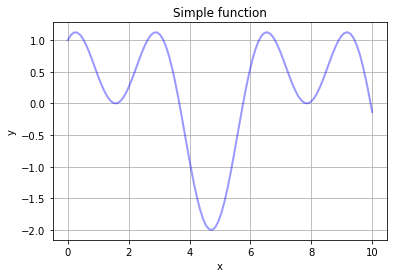

In [3]:
# Using the simple function
simple_f = my_blackbox.simple_func(np.linspace(0,10,n2))

plt.plot(np.linspace(0,10,n2), simple_f, linewidth=2, color='blue', alpha=0.4)
plt.title('Simple function')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

In [4]:
# Using the branin function
x1,x2 = np.meshgrid( np.linspace(-5, 10, n, dtype=float),
                     np.linspace(0, 15, n, dtype=float)) 
z = my_blackbox.branin(x1, x2, my_blackbox.a, my_blackbox.b, my_blackbox.c, my_blackbox.r, my_blackbox.s, my_blackbox.t)

# Create a plotly interactive graph
fig = go.Figure(data=[go.Surface(x=x1, y=x2, z=z, colorscale='viridis')]) # type: ignore

fig.update_layout(scene=dict(
                    xaxis=dict(title='X Axis'),
                    yaxis=dict(title='Y Axis'),
                    zaxis=dict(title='Z Axis')),
                    title='Branin function 3D Plot',
                    autosize=False,
                    width=800,
                    height=600,
                    margin=dict(l=65, r=50, b=65, t=90))

# Display the plot
fig.show()

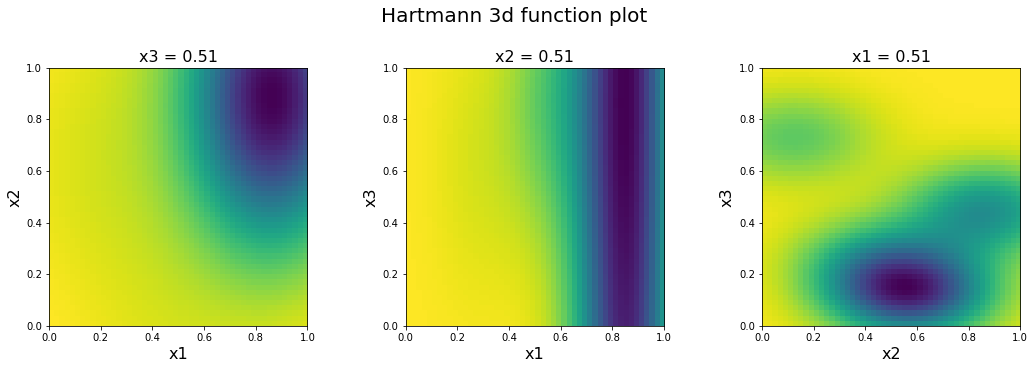

In [5]:
# Using the Hartmann function
x1 = np.linspace(0, 1, n)
x2 = np.linspace(0, 1, n)
x3 = np.linspace(0, 1, n)

xx = np.array(np.meshgrid(x1, x2, x3)).T.reshape(-1, 3)

y_values = my_blackbox.hartmann3d(x1,x2,x3, n, my_blackbox.alpha, my_blackbox.A, my_blackbox.P)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle('Hartmann 3d function plot \n', fontsize = 20)

for i, ax in enumerate(axs):
    if i == 0:
        ax.imshow(y_values[:, :, n // 2], extent=[x1.min(), x1.max(), x2.min(), x2.max()])
        ax.set_title('x3 = {:.2f}'.format(x3[n // 2]),fontsize = 16)
        ax.set_xlabel('x1',fontsize = 16)
        ax.set_ylabel('x2',fontsize = 16)
    elif i == 1:
        ax.imshow(y_values[:, n // 2, :], extent=[x1.min(), x1.max(), x3.min(), x3.max()])
        ax.set_title('x2 = {:.2f}'.format(x2[n // 2]),fontsize = 16)
        ax.set_xlabel('x1',fontsize = 16)
        ax.set_ylabel('x3',fontsize = 16)
    else:
        ax.imshow(y_values[n // 2, :, :].T, extent=[x2.min(), x2.max(), x3.min(), x3.max()])
        ax.set_title('x1 = {:.2f}'.format(x1[n // 2]),fontsize = 16)
        ax.set_xlabel('x2',fontsize = 16)
        ax.set_ylabel('x3',fontsize = 16)

plt.tight_layout()
plt.show()

## 1.4 Acquisition function

In this section we explain the precise process or strategy for choosing the order of query points $x_{1:n}$. While random selection is an option, it's inefficient. Instead, various strategies in literature use the posterior model to guide the sequential search, determining the next query point $x_{n+1}$ based on $\mathcal{D}_n=\{(x_1,y_1),...,(x_n,y_n)\}$.

Acquisition functions are designed to balance between exploring new areas of the search space and exploiting the current promising areas.

Once an acquisition function is employed to identify the next hyperparameter, the actual score of this new hyperparameter based on the true objective function is acquired. Because the surrogate model has been trained on pairs of (hyperparameter, true objective function score), incorporating a new data point updates the surrogate model.

In the following we will consider x, the query point, its corresponding function value $\nu = f(x)$ and the model hyperparameters $\theta$. We will marginalize the unseen outcome y and the unknown model hyperparameters $\theta$.

#### PI acquisition function
Probability of improvement acquisition function is an improvement-based acquisition function, meaning that it favors points that are likely to improve upon a certain time.
This function measures the probability that a point x leads to an improvement upon $\tau$. We can analytically compute this probability as follows:
$$
\alpha_{PI}(x;\mathcal{D}_n) := \mathcal{P}[\nu > \tau] = \Phi\left(\frac{\mu_n(x) - \tau}{\sigma_n(x)}\right)
$$

where $\Phi$ is the standard normal cumulative distribution function. As we can see from the formula PI considers the difference between the mean prediction and the current best value, taking into account the uncertainty in the surrogate model. $\alpha_{PI}(x;\mathcal{D}_n)$ is then maximized to select the next query point.

#### EI acquisition function
PI is often a good solution for the choice of the acquisition function when the target is known; in general, however the heuristic used for an unknown target causes PI to exploit quite aggressively.    
We can consider a differen acquisition function (EI).    
This new criterion corresponds to a different utility function,the improvement function, denoted by $I(x)$, which is defined as follows: 
$$I(\text{x}, \nu,\theta)=(\nu-\tau)\mathbb{I}(\nu>\tau)$$
and it has positive value only if there is an improvement. Since $\nu$ is normally distributed, the *expectation of improvement* can be computed as:
$$\alpha_{EI}(\text{x},\mathcal{D}_n)=\mathbb{E}[I(\text{x}, \nu,\theta)]=(\mu_n(\text{x}-\tau))\Phi \left(\dfrac{\mu_n(\text{x})-\tau}{\sigma_n(\text{x})}\right)  + \sigma_n(\text{x})\phi\left(\dfrac{\mu_n(\text{x})-\tau}{\sigma_n(\text{x})}\right) $$
when $\sigma_n>0$ (it vanishes otherwise); in this expression:
- $\Phi$ is the standard normal cumulative distribution function
- $\phi$ is the standard normal probability distribution function.    
    
    

>*Note on the parameter $\tau$*:
>although the target value (the best reachable objective value) is often unknown, in practice $\tau$ is adaptively set to be the best observed value ($\tau=y^+=max_{i=1:n}y_i$)


##### Acquisition functions

In [6]:
# Acquisition function
def prob_i(x, gp_model, best_y):
    if len(x.shape)==1 or x.shape[1]==1:
        y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    else:
        y_pred, y_std = gp_model.predict(x, return_std=True)
    z = (y_pred - best_y) / y_std
    pi = norm.cdf(z)
    return pi

def expected_i(x, gp_model, best_y):
    if len(x.shape)==1 or x.shape[1]==1:
        y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    else:
        y_pred, y_std = gp_model.predict(x, return_std=True)
    z = (y_pred - best_y) / y_std
    ei = (y_pred - best_y) * norm.cdf(z) + y_std * norm.pdf(z)
    return ei

# 2. Handling Hyperparameters

**Parameters:**
theta = [$\theta_0,\theta_i$], $i=1,..,d$ $\rightarrow$ d+1 total hyperparameters
- $\theta_0$ is the square root of the multiplication constant of the kernel
- $\theta_i$ ($i=1,..d$) are the length scales

### 2.1 Maximum likelihood

### 2.2 Sequential Monte-Carlo    

In SMC we iteratively update a sample of size N, using information from the data to approximate better the posterior.    
The basic Idea is the following:
 1. Obtain a sequence of samples of theta distributed approximately as the posterior
 2. average the acquisition function over those samples
 
SMC takes care of the first point. If we want to sample from the posterior distribution $p(\theta,D_n)$, this distribution is not easily integrabel and the dependencies on $\theta$ are not trivial.    
We can then make use of the so called **Importance Sampling** technique.    
We approximate $$p(\theta|D_n) \simeq w(\theta) \pi(\theta|D_n)$$
where
- $\pi(\theta|D_n)$ importance sampling density: can have different forms, often a delta distribution;
- $w(\theta)$ : importance sampling weight: associates an 'importance'to each value of $\theta$ based on maximum likelihood 
With this approximation, we can write: $$E_{\theta|D_n}[\alpha(x,\theta)]=\int \alpha(x,theta)p(\theta|D_n)d\theta \simeq \sum_{i=1}^N \alpha(\theta^{(i)})w_t^{(i)}$$

(averaged over $N$ samples of the hyperparameters).
The goodness of this algorithm resides on taking a good sample of hyperparameters, which is therefore determined by the appropriate weights. Here follows the algorithm:

Given:
- $p(\theta_0)$ : prior of hyperparameters
- $p(\theta_t|\theta_{t-1})$ : prior of transition probabilities
- $p(y_t|\theta)=\dfrac{e^{-\dfrac{1}{2}(y_t K(\theta)^{-1})y_t}}{\sqrt{|2\pi K(\theta)|}}$  likelihood of inferred $y_t$ given a set of hyperparameters

We proceed as follows:

> 1. Before training: initialize a sample of size N (same size of x and y) of hyperparameters according to the prior distribution    

> 2. For each iteration t of training:    
    >- For $i=0,...,N-1$    
        > #add a new sample of N hyperparameters, one by one    
        >$\theta_t^{(i)}\sim p(\theta_t^{(i)}|\theta_{t-1}^{(i)}$    
        
>$\theta_{0:t}=[\theta_{0:t-1},\theta_t]$   
    >- For $i=0,...N-1$:    
    >#compute weights with likelihood    
        >$w_t^{(i)}=p(y_t|\theta_t^{(i)})$       ($y_t$ is the best y obtained in the training iteration)    
        >Substitute the 'layer' t of hyperparameters by resampling N hyperparameters (one by one) using the weights

    
    

**Note on the function below**:
the kernel has to be a semidefinite positive matrix: if one of the hyperparameters is $<0$ it doesn't work, it returns nan and it doesn't do anything;  the problem is that, since we choose theta at each $t$ from a gaussian which can be centered anywhere, we may also have negative values; The problem is solved if we don't start with zero mean gaussians and we take a small variance.    
Also, in the 2D case, a scaling factor is added to the weights to avoid underflow.


In [7]:
def smc(x,y,N,k_dim,T, var):
    
    '''Parameters:
    
    - x = sample of x
    - y = sample of y
    - N = number of samples for smc
    - k_dim = number of hyperparameters
    - theta_opt = best parameters found with max likelihood
    - var = theta_opt/100
    
    Output: theta_best = optimized hyperparameters'''
    
    #inizialization
    theta = np.zeros((N,k_dim,T))
    theta[:,:,0] = np.full((N,k_dim), 10) #to avoid negative theta we start far from 0
    w = np.zeros((N,T))
    
    
    for t in range(1, T):
        for i in range(N):
            for j in range(k_dim):
                theta[i,j,t] = np.random.normal(loc=theta[i,j,t-1], scale=var[j])
            
            
            #compute weights (gp needs to be computed with each set of hyperpars)
            if k_dim==2:
                kernel = (theta[i,0,t]**2) * Matern(length_scale=theta[i,1,t], nu=1.5)
                gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, alpha=1e-5)
                gp.fit(x.reshape(-1, 1),y)
            elif k_dim==3:
                kernel = (theta[i,0,t]**2) * Matern(length_scale=[theta[i,1,t],theta[i,2,t]], nu=1.5)
                gp = GaussianProcessRegressor(kernel=kernel, optimizer=None, alpha=1e-5)
                gp.fit(x,y)
                
            w[i,t] = np.exp(gp.log_marginal_likelihood()*1e-3) #scaled to avoid underflow; will be normalized, so no worry

        #normalize weights
        w[:,t]/=np.sum(w[:,t])
        
        '''start resampling'''
        #print(w[:,t])
        #resample with replacement:
        for i in range(N):
            index = np.random.choice(N, size=1, p=w[:,t])
            theta[i,:,t] = theta[index,:,t]
        
    theta_best = np.mean(theta[:,:,T-1], axis=0)
    return theta_best

### 2.3 Vihola algorithm 

# 3. Bayesian optimization 

## A) 1-Dimension: Simple function

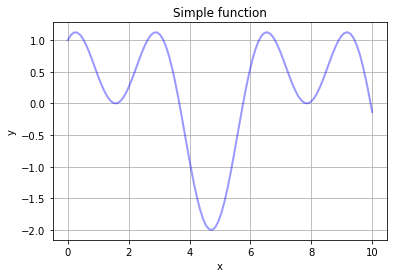

In [8]:
# Generate a grid and plot the simple function
x_grid = np.linspace(0,10,n2)
simple_f = my_blackbox.simple_func(x_grid)

plt.plot(np.linspace(0,10,n2), simple_f, linewidth=2, color='blue', alpha=0.4)
plt.title('Simple function')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

##### Initial sampling

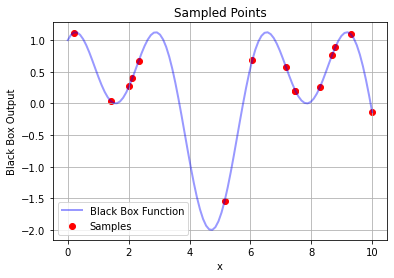

In [9]:
# Sample 5 outputs from function f
n_sample = 15
sample_x = np.random.choice(x_grid, n_sample)

# output for each sampled x value
sample_y =  my_blackbox.simple_func(sample_x)

# plot
plt.plot(x_grid, simple_f, label='Black Box Function',linewidth=2, color='blue', alpha=0.4)
plt.scatter(sample_x, sample_y, color='red', label='Samples')
plt.xlabel('x')
plt.ylabel('Black Box Output')
plt.title('Sampled Points')
plt.legend()
plt.grid()
plt.show()


#### Function for training

In [10]:
def plot_1D(x_grid, my_blackbox, improv, y_pred, y_std, sample_x, sample_y):
    plt.plot(x_grid, my_blackbox.simple_func(x_grid), color='orange', label='Black Box Function', linewidth=2, alpha=0.7)
    plt.plot(x_grid, 10*improv, color='red', linestyle='dashed', label='10 x Surrogate Function', alpha=0.8)
    plt.fill_between(x_grid, y_pred - 2*y_std, y_pred + 2*y_std, color='blue', alpha=0.2)
    plt.plot(x_grid, y_pred, color='blue', label='Gaussian Process', alpha=0.7, linewidth=2)
    plt.scatter(sample_x, sample_y, color='red', label='Previous Points')

In [11]:
def make_gif(folder_path, frames):
    gif_path = os.path.join(folder_path, 'simple_optimization_ei.gif')

    with imageio.get_writer(gif_path, mode='I', duration=0.2) as writer:
        for frame in frames:
            image = imageio.imread(os.path.join(folder_path, frame))
            writer.append_data(image)


In [12]:
def optimize_d1(sample_x, sample_y, x_grid, optimizer, num_iterations, folder_path, acquisition,N,T,var, k_dim):
    frames = []
    plt.figure(figsize=(10, 6))

    # Determine the initial limits of the plot
    y_min = min(sample_y) - 1
    y_max = max(sample_y) + 1
    x_min = min(sample_x) - 1
    x_max = max(sample_x) + 1

  
    # Gaussian process
    kernel = 1.0 * Matern(length_scale=2.0, nu=1.5)
    
    if (optimizer=="fmin_l_bfgs_b"):
        gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, optimizer= "fmin_l_bfgs_b")
    # if it's smc it will be initialized after
    #eventually add here also vihola condition
        
    theta_best = [1.0,2.0] #initial values for smc

    for i in range(num_iterations):
        print('Iteration number : ', i)
        
        #Update of kernel (automatic if optimizer = lbfgs)
        if (optimizer=='smc'):
            #Manually update kernel hyperparameters
            kernel = theta_best[0]**2 * Matern(length_scale=theta_best[1], nu=1.5)
            gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, optimizer= None)
            
        # Fit the Gaussian process model to the sampled points
        gp_model.fit(sample_x.reshape(-1, 1), sample_y)

        # Determine the point with the highest observed function value
        best_idx = np.argmax(sample_y)
        best_x = sample_x[best_idx]
        best_y = sample_y[best_idx]

        # Generate the acquisition function using the Gaussian process model
        y_pred, y_std = gp_model.predict(x_grid.reshape(-1, 1), return_std=True)
        
        if acquisition == 0:
            improv = expected_i(x_grid.reshape(-1, 1), gp_model, best_y)
        if acquisition == 1:
            improv = prob_i(x_grid.reshape(-1, 1), gp_model, best_y)

        # Plot the black box function, surrogate function, previous points, and new points
        plot_1D(x_grid, my_blackbox, improv, y_pred, y_std, sample_x, sample_y)
        
        if i < num_iterations - 1:
            new_x = x_grid[np.argmax(improv)]  # Select the next point based on UCB
            new_y = my_blackbox.simple_func(new_x)
            sample_x = np.append(sample_x, new_x)
            sample_y = np.append(sample_y, new_y)
            plt.scatter(new_x, new_y, color='green', label='New Points')

        if (optimizer=='smc'):
            '''Optimization of hyperparameters with smc'''
            theta_best = smc(sample_x,sample_y,N,k_dim,T,var)
        
        
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f"Iteration #{i+1}")
        plt.legend()
        plt.grid()

        # Set the fixed limits for the plot
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        # Save frame
        filename = f"frame_{i}.png"
        plt.savefig(os.path.join(folder_path, filename))
        frames.append(filename)
        plt.clf()  # Clear current figure
        

    # Create the GIF using the frames saved in the specified folder
    make_gif(folder_path, frames)

    # Remove the saved frames
    for frame_file in frames:
        os.remove(os.path.join(folder_path, frame_file))

    final_x = sample_x
    final_y = sample_y
    print('Optimized theta: ', gp_model.kernel_)
    
    return(final_x , final_y)
        

### A.1 : Training with max likelihood

In [14]:
#display the evolution with expected improvment
N=T=var=k_dim=0 #no smc
num_iterations = 25
optimizer = "fmin_l_bfgs_b"
folder_path = '/home/sara/Scrivania/Physics_of_Data/2nd_Year/Information_theory'
acquisition = 0
final_x_ml, final_y_ml = optimize_d1(sample_x, sample_y, x_grid, optimizer, num_iterations, folder_path, acquisition, N, T, var, k_dim)

Iteration number :  0
Iteration number :  1


/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



Iteration number :  2
Iteration number :  3
Iteration number :  4
Iteration number :  5
Iteration number :  6
Iteration number :  7
Iteration number :  8
Iteration number :  9
Iteration number :  10
Iteration number :  11
Iteration number :  12
Iteration number :  13
Iteration number :  14
Iteration number :  15
Iteration number :  16
Iteration number :  17
Iteration number :  18
Iteration number :  19
Iteration number :  20
Iteration number :  21
Iteration number :  22
Iteration number :  23
Iteration number :  24
Optimized theta:  1.27**2 * Matern(length_scale=2.02, nu=1.5)


<Figure size 720x432 with 0 Axes>

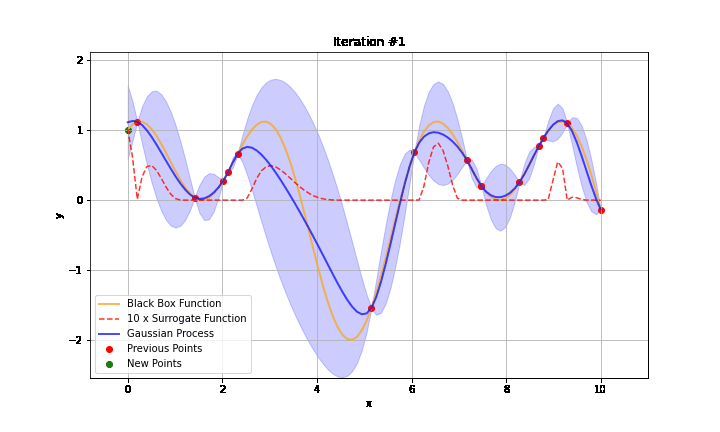

In [15]:
gif_path = os.path.join(folder_path, 'simple_optimization_ei.gif')
display(Image(filename=gif_path))

### A.2 : Training with Sequential monte Carlo

In [19]:
#display the evolution with expected improvment
num_iterations = 25
folder_path = '/home/sara/Scrivania/Physics_of_Data/2nd_Year/Information_theory'
acquisition = 0 #ei
optimizer = "smc"

In [21]:
#best values from max likelihood /100
#variances of Gaussians
var = [1.27/100,2.02/100]

N = 100
T = 25
k_dim = 2


final_x_smc,final_y_smc = optimize_d1(sample_x, sample_y, x_grid, optimizer, num_iterations, folder_path, acquisition, N, T,var, k_dim)


Iteration number :  0
Iteration number :  1
Iteration number :  2
Iteration number :  3
Iteration number :  4
Iteration number :  5
Iteration number :  6
Iteration number :  7
Iteration number :  8
Iteration number :  9
Iteration number :  10
Iteration number :  11
Iteration number :  12
Iteration number :  13
Iteration number :  14
Iteration number :  15
Iteration number :  16
Iteration number :  17
Iteration number :  18
Iteration number :  19
Iteration number :  20
Iteration number :  21
Iteration number :  22
Iteration number :  23
Iteration number :  24
Optimized theta:  9.94**2 * Matern(length_scale=10, nu=1.5)


<Figure size 720x432 with 0 Axes>

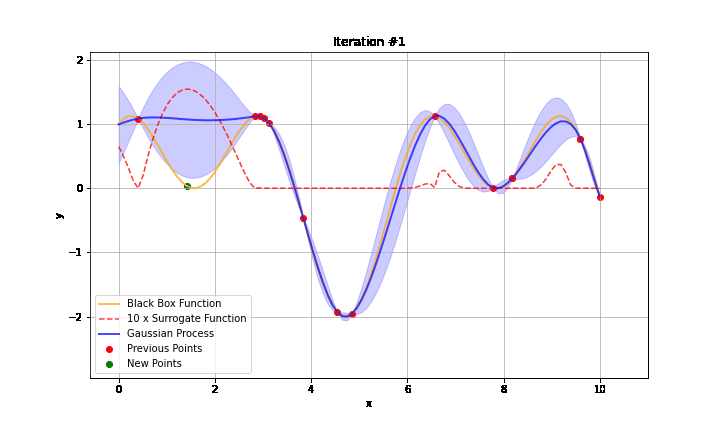

In [22]:
gif_path = os.path.join(folder_path, 'simple_optimization_smc.gif')
display(Image(filename=gif_path))

## B) 2-Dimensions : Branin function

#### Initial Sampling

In [23]:
def sampling(x1: np.ndarray, x2: np.ndarray, n_sample: int, a: float, b: float, c: float, r: float, s: float, t: float )-> tuple[np.ndarray, np.ndarray]:
    """_summary_

    Args:
        x1 (np.ndarray): _description_
        x2 (np.ndarray): _description_
        n_sample (int): _description_
        a (float): _description_
        b (float): _description_
        c (float): _description_
        r (float): _description_
        s (float): _description_
        t (float): _description_

    Returns:
        tuple[np.ndarray, np.ndarray]: _description_
    """
    s_x = np.zeros((n_sample,2), dtype=float)
    s_x[:,0] = np.random.choice(x1[0,:], n_sample)
    s_x[:,1] = np.random.choice(x2[:,0], n_sample)
    
    s_z = np.zeros_like(s_x, dtype=float)
    s_z = my_blackbox.branin(s_x[:,0], s_x[:,1], a=a, b=b, c=c, r=r, s=s, t=t)

    return s_x, s_z


In [24]:
n = 50

x1,x2 = np.meshgrid( np.linspace(-5, 10, n, dtype=float),
                     np.linspace(0, 15, n, dtype=float)) # grid of points
matriX = np.column_stack((x1.ravel(),x2.ravel()))

n_sample = 30
sample_x, sample_y = sampling(x1, x2, n_sample, my_blackbox.a, my_blackbox.b, my_blackbox.c, my_blackbox.r, my_blackbox.s, my_blackbox.t)
reference=sample_x[:,1].min() #Reference point sampled for the plot in 1D

#### Function for plotting 2D surface variance

In [25]:
def plot_3d_surface_variance(x1, x2, y_values, y_std):
    y_values_reshaped = y_values.reshape(x1.shape)
    y_std_reshaped = y_std.reshape(x1.shape)

    fig = go.Figure(data=[go.Surface(x=x1, y=x2, z=y_values_reshaped, colorscale='Viridis', name='ypred')])

    fig.add_trace(go.Surface(x=x1, y=x2, z=y_values_reshaped + y_std_reshaped, colorscale='Viridis',showscale=False, opacity=0.6, name='ypred + y_std'))
    fig.add_trace(go.Surface(x=x1, y=x2, z=y_values_reshaped - y_std_reshaped, colorscale='Viridis',showscale=False, opacity=0.6, name='ypred - y_std'))

    # Set layout
    fig.update_layout(scene=dict(
                        xaxis_title='X1',
                        yaxis_title='X2',
                        zaxis_title='Acquisition function'))
    
    # Show plot
    fig.show()
    
#plot_3d_surface_variance(x1, x2, y_pred,y_std)


#### Function for optimization

In [33]:
def optimize_2d(x, y, x1, x2, optimizer, num_iterations, acquisition, N, T, var, k_dim):

    if (optimizer=="fmin_l_bfgs_b"):
        kernel = 1.0 * Matern(length_scale=[1.0,1.0], nu=1.5)
        #the line below caused problems: it lead to hyperpars too high
        #kernel.set_params(**{'k1__constant_value_bounds': (1e-05, 10000000.0)}) #increase upper bound to avoid convergence warnings
        gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, optimizer= "fmin_l_bfgs_b")

    theta_best = [1.0,1.0,1.0] #initial hyperpars if we use smc
    
    for i in range(num_iterations): 
        
        print('Iteration: ', i)
        
        if (optimizer=="smc"):
            kernel = theta_best[0] * Matern(length_scale=[theta_best[1],theta_best[2]], nu=1.5)
            gp_model = GaussianProcessRegressor(kernel=kernel, optimizer=None)
            
        gp_model.fit(x,y)
    
        # Generate predictions using the Gaussian process model
        matriX = np.column_stack((x1.ravel(),x2.ravel()))
        y_pred, y_std = gp_model.predict(matriX, return_std=True)
    
        best_idx = np.argmax(y)
        best_x = x[best_idx]
        best_y = y[best_idx]
    
        if acquisition==0:
            improv = expected_i(matriX,gp_model,best_y)
        else:
            improv = prob_i(matriX,gp_model,best_y)
            
        
        if i < num_iterations - 1:
            new_x = matriX[np.argmax(improv)].reshape(-1,2)  # Select the next point based on
            #new_y = branin(new_x[0,0],new_x[0,1],a, b, c, r, s, t)
            new_y = my_blackbox.branin(new_x[0,0],new_x[0,1], my_blackbox.a, my_blackbox.b, my_blackbox.c, my_blackbox.r, my_blackbox.s, my_blackbox.t)
            x = np.concatenate((x, new_x))
            y = np.append(y, new_y)
        
        if (optimizer=="smc"):
            #Optimize hyperpars with smc
            theta_best = smc(x,y,N,k_dim,T,var)
    
    # Final plot
    plot_3d_surface_variance(x1, x2, y_pred,y_std)
    
    #Final data
    x_2d = x
    y_2d = y
        
    print('Optimized theta: ', gp_model.kernel_)
    return(x_2d,y_2d)
    
    

### B.1 : Training with max likelihood

In [34]:
optimizer = "fmin_l_bfgs_b"
num_iterations = 30
acquisition = 0 #(use expected improvement)
N=T=var=k_dim=0 #no smc

In [35]:
x_2d_ml, y_2d_ml = optimize_2d(sample_x, sample_y, x1, x2, optimizer, num_iterations, acquisition, N, T, var, k_dim)

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7


/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.

Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14


/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.

Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20


/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:

Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26


/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussia

Iteration:  27
Iteration:  28
Iteration:  29


/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.

/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

/home/sara/anaconda3/lib/python3.9/site-packages/sklearn/gaussia

Optimized theta:  316**2 * Matern(length_scale=[18.2, 46], nu=1.5)


In [36]:
index = np.argmax(y_2d_ml)
best_x = x_2d_ml[index,:]
best_y = y_2d_ml[index]
print("The maximum value found is : ", best_y, "at coordinates : ", best_x)

The maximum value found is :  308.12909601160663 at coordinates :  [-5.  0.]


### B.2 : Training with sequential Monte Carlo

In [39]:
k_dim = 3
N = 100
T = 25
var = [316/100,18.2/100,46/100]
optimizer = "smc"
num_iterations = 30
acquisition = 0 #(use expected improvement)

In [40]:
x_2d_smc, y_2d_smc = optimize_2d(sample_x, sample_y, x1, x2, optimizer, num_iterations, acquisition, N, T, var, k_dim)

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29


Optimized theta:  5.89**2 * Matern(length_scale=[9.08, 9.94], nu=1.5)


In [42]:
index = np.argmax(y_2d_smc)
best_x = x_2d_smc[index,:]
best_y = y_2d_smc[index]

print("The maximum value found is : ", best_y, "at coordinates : ", best_x)

The maximum value found is :  308.12909601160663 at coordinates :  [-5.  0.]


### Training con gif

In [ ]:
pip install kaleido

In [ ]:
from PIL import Image
import os
folder_path = '/home/sara/Scrivania/Physics_of_Data/2nd_Year/Information_theory'
n_iter = 10
x = sample_x
y = sample_y

# Definisci la funzione per la rappresentazione della superficie 3D con varianza
def plot_3d_surface_variance(x1, x2, y_values, y_std,iteration_number, filename=None):
    y_values_reshaped = y_values.reshape(x1.shape)
    y_std_reshaped = y_std.reshape(x1.shape)

    fig = go.Figure(data=[go.Surface(x=x1, y=x2, z=y_values_reshaped, colorscale='Viridis', name='Predicted Branin Function')])

    fig.add_trace(go.Surface(x=x1, y=x2, z=y_values_reshaped + y_std_reshaped, colorscale='Viridis',showscale=False, opacity=0.6, name='Predicted Branin Function + Std Dev'))
    fig.add_trace(go.Surface(x=x1, y=x2, z=y_values_reshaped - y_std_reshaped, colorscale='Viridis',showscale=False, opacity=0.6, name='Predicted Branin Function - Std Dev'))

    # Set layout
    fig.update_layout(scene=dict(
                        xaxis_title='X1',
                        yaxis_title='X2',
                        zaxis_title='Predicted Branin Function'),
                        title=f'Iteration {iteration_number}')

    # Save plot as image
    if filename:
        fig.write_image(filename)

frames = []

for i in range(n_iter):
    # Addestrare il modello Gaussian Process
    gp_model.fit(x, y)
    
    # Generare le predizioni utilizzando il modello Gaussian Process
    y_pred, y_std = gp_model.predict(matriX, return_std=True)
    
    # Creare il plot 3D della superficie con varianza e salvarlo come immagine temporanea
    filename = f"frame_{i}.png"
    plot_3d_surface_variance(x1, x2, y_pred, y_std,i, filename)
    
    # Aggiungere l'immagine alla lista dei frame
    frames.append(Image.open(filename))
    
    best_idx = np.argmax(y)
    best_x = x[best_idx]
    best_y = y[best_idx]
    
    if poi==True:
        improv = prob_i(matriX,gp_model,best_y)
    else:
        improv = expected_i(matriX,gp_model,best_y)
        
    if i < n_iter - 1:
        new_x = matriX[np.argmax(improv)].reshape(-1,2)  # Select the next point based on
        new_y = my_blackbox.branin(new_x[0,0],new_x[0,1], my_blackbox.a, my_blackbox.b, my_blackbox.c, my_blackbox.r, my_blackbox.s, my_blackbox.t)
        x = np.concatenate((x, new_x))
        y = np.append(y, new_y)
        
# Creare la GIF utilizzando i frame salvati nella cartella specificata
gif_path = os.path.join(folder_path, '/branin_optimization.gif')
frames[0].save(gif_path, save_all=True, append_images=frames[1:], optimize=False, duration=200, loop=0)

# Rimuovere i frame salvati
for frame_file in os.listdir(folder_path):
    if frame_file.startswith('frame_') and frame_file.endswith('.png'):
        os.remove(os.path.join(folder_path, frame_file))
